In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_66Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_AllAgree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/README.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/License.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_75Agree.txt
/kaggle/input/sentiment-analysis-for-financial-news/FinancialPhraseBank/Sentences_50Agree.txt


In [2]:
!pip install text_hammer
!pip install transformers
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab
import text_hammer as th
import numpy as np
import pandas as pd
import seaborn as sns
from array import *
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from transformers import BertTokenizer,TFBertModel
#tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')
import shutil
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

def batch_selector(dataset,samples_no):
    training_batch=dataset.iloc[:samples_no]
    unlabelled_batch=dataset.iloc[samples_no:]
    return training_batch, unlabelled_batch
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

def num_sim(n1, n2):
  """ calculates a similarity score between 2 numbers """
  return 1 - abs(n1 - n2) / (n1 + n2)

def maxConflictFinder(array):
    a_list = list(array)
    are= list(array)
    max_value = max(a_list)
    max_index = a_list.index(max_value)
    maxele=a_list.pop(max_index)
    for i in range(len(a_list)):
        intdiff=num_sim(a_list[i],maxele)
        if((intdiff>0.90)):
            return are.index(a_list[i]),are.index(maxele)
        else:
            return None

def indexGenerator(df):
    n,_=df.shape
    index=np.arange(0,n)
    df['index']=index
    df=df.set_index('index')
    return df

def dataTx(n,df_test,df_train):
    df_train=df_train.append(df_test[n:n+1])
    df_test=df_test.drop(n)
    return df_test,df_train

def dataTx_trial(txlist,df_test1,df_train1):
    for n in txlist:
        df_train1=df_train1.append(indexGenerator((df_test1.iloc[n].to_frame()).transpose()))
    for k in txlist:
        df_test1=df_test1.drop(k)
    return df_test1,df_train1

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

df_full = pd.read_csv('../input/sentiment-analysis-for-financial-news/all-data.csv', names=['Sentiment', 'Input'], encoding='latin-1')
df_neutral=df_full[df_full['Sentiment']=='neutral']
df_negative=df_full[df_full['Sentiment']=='negative']
df_positive=df_full[df_full['Sentiment']=='positive']
print(f'neutral:{df_neutral.shape}')
print(f'negativer:{df_negative.shape}')
print(f'positive:{df_positive.shape}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Uninstalling beautifulsoup4-4.11.1:
      Successfully uninstalled beautifulsoup4-4.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompati

2022-11-20 14:52:39.539681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 14:52:39.540562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 14:52:39.541566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 14:52:39.542298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 14:52:39.542995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-11-20 14:53:54.400045: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

neutral:(2879, 2)
negativer:(604, 2)
positive:(1363, 2)


In [3]:
No_samples=100
neutral_train,neutral_test=batch_selector(df_neutral,No_samples)
negative_train,negative_test=batch_selector(df_negative,No_samples)
positive_train,positive_test=batch_selector(df_positive,No_samples)
train250= pd.concat([neutral_train,negative_train,positive_train], axis = 0)
test250= pd.concat([neutral_test,negative_test,positive_test], axis = 0)
df_test,df_train=test250,train250
print(df_test.shape,df_train.shape)

(4546, 2) (300, 2)


In [4]:


df_cleaned_train_20 = text_preprocessing(train250,'Input')
df_cleaned_test_20 = text_preprocessing(test250,'Input')
train20_df = df_cleaned_train_20.copy()
test20_df = df_cleaned_test_20.copy()
train20_df['num_words'] = train20_df.Input.apply(lambda x:len(x.split()))
test20_df['num_words'] = test20_df.Input.apply(lambda x:len(x.split()))
train20_df['Sentiment'] = train20_df.Sentiment.astype('category')
test20_df['Sentiment'] = test20_df.Sentiment.astype('category')
train20_df['Sentiment']  =  train20_df.Sentiment.cat.codes
test20_df['Sentiment']  =  test20_df.Sentiment.cat.codes

from sklearn.model_selection import train_test_split
data_train,data_test = train_test_split(train20_df, test_size = 0.30, random_state = 42, stratify = train20_df.Sentiment)

surprise_string ='i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies '
len(surprise_string)
res = len(surprise_string.split())
print("The number of words in string are : " + str(res),len(surprise_string) )
data_test = data_test.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
data_train = data_train.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
data_val = test20_df.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)

x_train = tokenizer(
    text=data_train.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test = tokenizer(
    text=data_test.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_val = tokenizer(
    text=data_val.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

max_len = 70
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(3,activation = 'sigmoid')(out)
    
model4 = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model4.layers[2].trainable = True

optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model4.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

train_history = model4.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train.Sentiment),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.Sentiment)
    ),
  epochs=10,
    batch_size=36
)

predicted_raw = model4.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})
y_predicted = np.argmax(predicted_raw, axis = 1)
print(classification_report(data_val.Sentiment, y_predicted))
print(confusion_matrix(data_val.Sentiment,y_predicted))
cf_matrix=confusion_matrix(data_val.Sentiment,y_predicted)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

The number of words in string are : 115 565


2022-11-20 14:57:54.174134: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
6/6 [==============================] - 5s 776ms/step - loss: 1.1235 - balanced_accuracy: 0.3128 - val_loss: 1.0149 - val_balanced_accuracy: 0.3736
Epoch 2/10
6/6 [==============================] - 4s 708ms/step - loss: 0.8616 - balanced_accuracy: 0.6635 - val_loss: 0.8573 - val_balanced_accuracy: 0.6593
Epoch 3/10
6/6 [==============================] - 4s 716ms/step - loss: 0.6314 - balanced_accuracy: 0.8199 - val_loss: 0.6796 - val_balanced_accuracy: 0.7692
Epoch 4/10
6/6 [==============================] - 4s 740ms/step - loss: 0.4488 - balanced_accuracy: 0.8531 - val_loss: 0.5590 - val_balanced_accuracy: 0.7912
Epoch 5/10
6/6 [==============================] - 4s 727ms/step - loss: 0.3107 - balanced_accuracy: 0.9100 - val_loss: 0.4779 - val_balanced_accuracy: 0.8132
Epoch 6/10
6/6 [==============================] - 5s 801ms/step - loss: 0.2026 - balanced_accuracy: 0.9526 - val_loss: 0.4887 - val_balanced_accuracy: 0.8132
Epoch 7/10
6/6 [==============================] - 4s

In [9]:
print(df_test.shape,df_train.shape)

(4194, 2) (652, 2)


In [7]:
print(df_test.shape,df_train.shape)


(4194, 2) (652, 2)


In [ ]:
df_test,df_train=test250,train250
print(df_test.shape,df_train.shape)

In [12]:
df_test,df_train=test250,train250
print(df_test.shape,df_train.shape)

(4546, 3) (300, 3)


In [5]:
df_cleaned_train_20 = text_preprocessing(df_train,'Input')
df_cleaned_test_20 = text_preprocessing(df_test,'Input')
train20_df = df_cleaned_train_20.copy()
test20_df = df_cleaned_test_20.copy()
train20_df['num_words'] = train20_df.Input.apply(lambda x:len(x.split()))
test20_df['num_words'] = test20_df.Input.apply(lambda x:len(x.split()))
train20_df['Sentiment'] = train20_df.Sentiment.astype('category')
test20_df['Sentiment'] = test20_df.Sentiment.astype('category')
train20_df['Sentiment']  =  train20_df.Sentiment.cat.codes
test20_df['Sentiment']  =  test20_df.Sentiment.cat.codes

from sklearn.model_selection import train_test_split
data_train,data_test = train_test_split(train20_df, test_size = 0.30, random_state = 42, stratify = train20_df.Sentiment)

surprise_string ='i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies '
len(surprise_string)
res = len(surprise_string.split())
print("The number of words in string are : " + str(res),len(surprise_string) )
data_test = data_test.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
data_train = data_train.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
data_val = test20_df.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)

x_train = tokenizer(
    text=data_train.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test = tokenizer(
    text=data_test.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_val = tokenizer(
    text=data_val.Input.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

max_len = 70
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(3,activation = 'sigmoid')(out)
    
model5 = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model5.layers[2].trainable = True

optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model5.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

train_history = model5.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train.Sentiment),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.Sentiment)
    ),
  epochs=10,
    batch_size=36
)

predicted_raw = model5.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})
y_predicted = np.argmax(predicted_raw, axis = 1)
print(classification_report(data_val.Sentiment, y_predicted))
print(confusion_matrix(data_val.Sentiment,y_predicted))
cf_matrix=confusion_matrix(data_val.Sentiment,y_predicted)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

  0%|          | 0/4546 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
6/6 [==============================] - 5s 782ms/step - loss: 0.8194 - balanced_accuracy: 0.6825 - val_loss: 0.4818 - val_balanced_accuracy: 0.7912
Epoch 2/10
6/6 [==============================] - 4s 757ms/step - loss: 0.3016 - balanced_accuracy: 0.9005 - val_loss: 0.4826 - val_balanced_accuracy: 0.7802
Epoch 3/10
6/6 [==============================] - 5s 795ms/step - loss: 0.1759 - balanced_accuracy: 0.9384 - val_loss: 0.5919 - val_balanced_accuracy: 0.7802
Epoch 4/10
6/6 [==============================] - 5s 768ms/step - loss: 0.0813 - balanced_accuracy: 0.9858 - val_loss: 0.6212 - val_balanced_accuracy: 0.7582
Epoch 5/10
6/6 [==============================] - 5s 833ms/step - loss: 0.0562 - balanced_accuracy: 0.9858 - val_loss: 0.7343 - val_balanced_accuracy: 0.7473
Epoch 6/10
6/6 [==============================] - 5s 876ms/step - loss: 0.0832 - balanced_accuracy: 0.9668 - val_loss: 0.7670 - val_balanced_accuracy: 0.7802
Epoch 7/

#################### 1 ###########################
61
(4485, 2) (361, 2)


  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/361 [00:00<?, ?it/s]

  0%|          | 0/4485 [00:00<?, ?it/s]

  0%|          | 0/4485 [00:00<?, ?it/s]

  0%|          | 0/4485 [00:00<?, ?it/s]

  0%|          | 0/4485 [00:00<?, ?it/s]

  0%|          | 0/4485 [00:00<?, ?it/s]

  0%|          | 0/4485 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
8/8 [==============================] - 7s 822ms/step - loss: 0.5850 - balanced_accuracy: 0.7945 - val_loss: 0.6933 - val_balanced_accuracy: 0.7545
Epoch 2/10
8/8 [==============================] - 6s 739ms/step - loss: 0.3412 - balanced_accuracy: 0.8854 - val_loss: 0.5632 - val_balanced_accuracy: 0.8000
Epoch 3/10
8/8 [==============================] - 6s 749ms/step - loss: 0.1716 - balanced_accuracy: 0.9447 - val_loss: 0.4987 - val_balanced_accuracy: 0.8636
Epoch 4/10
8/8 [==============================] - 7s 844ms/step - loss: 0.1290 - balanced_accuracy: 0.9644 - val_loss: 0.5810 - val_balanced_accuracy: 0.7909
Epoch 5/10
8/8 [==============================] - 7s 869ms/step - loss: 0.0556 - balanced_accuracy: 0.9842 - val_loss: 0.6373 - val_balanced_accuracy: 0.7909
Epoch 6/10
8/8 [==============================] - 6s 772ms/step - loss: 0.0377 - balanced_accuracy: 0.9842 - val_loss: 0.6565 - val_balanced_accuracy: 0.8182
Epoch 7/

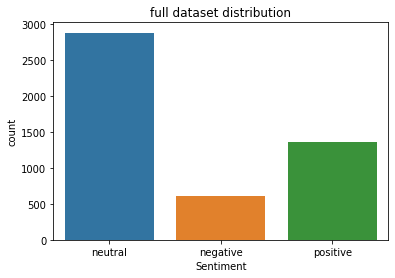

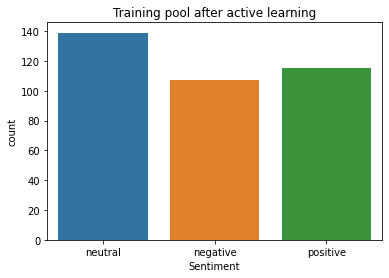

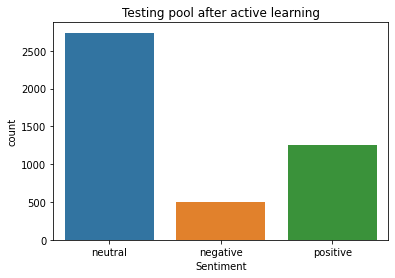

#################### 2 ###########################
72
(4413, 2) (433, 2)


  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/433 [00:00<?, ?it/s]

  0%|          | 0/4413 [00:00<?, ?it/s]

  0%|          | 0/4413 [00:00<?, ?it/s]

  0%|          | 0/4413 [00:00<?, ?it/s]

  0%|          | 0/4413 [00:00<?, ?it/s]

  0%|          | 0/4413 [00:00<?, ?it/s]

  0%|          | 0/4413 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
9/9 [==============================] - 7s 773ms/step - loss: 0.7795 - balanced_accuracy: 0.7500 - val_loss: 0.6220 - val_balanced_accuracy: 0.7786
Epoch 2/10
9/9 [==============================] - 7s 769ms/step - loss: 0.2668 - balanced_accuracy: 0.9211 - val_loss: 0.6727 - val_balanced_accuracy: 0.7939
Epoch 3/10
9/9 [==============================] - 8s 865ms/step - loss: 0.1139 - balanced_accuracy: 0.9638 - val_loss: 0.6740 - val_balanced_accuracy: 0.8015
Epoch 4/10
9/9 [==============================] - 7s 794ms/step - loss: 0.0741 - balanced_accuracy: 0.9836 - val_loss: 0.7880 - val_balanced_accuracy: 0.8015
Epoch 5/10
9/9 [==============================] - 7s 795ms/step - loss: 0.0697 - balanced_accuracy: 0.9770 - val_loss: 0.8539 - val_balanced_accuracy: 0.8092
Epoch 6/10
9/9 [==============================] - 7s 761ms/step - loss: 0.0279 - balanced_accuracy: 0.9901 - val_loss: 0.8682 - val_balanced_accuracy: 0.7863
Epoch 7/

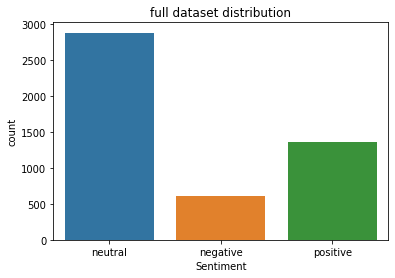

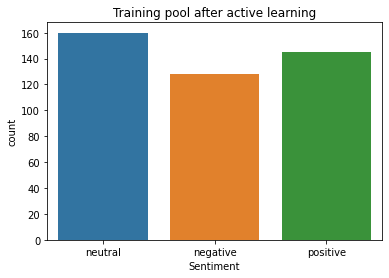

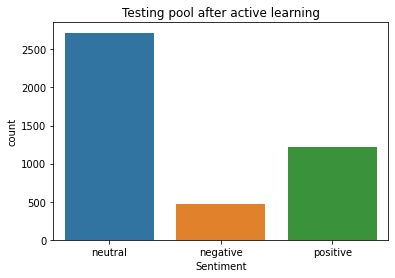

#################### 3 ###########################
16
(4397, 2) (449, 2)


  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/449 [00:00<?, ?it/s]

  0%|          | 0/4397 [00:00<?, ?it/s]

  0%|          | 0/4397 [00:00<?, ?it/s]

  0%|          | 0/4397 [00:00<?, ?it/s]

  0%|          | 0/4397 [00:00<?, ?it/s]

  0%|          | 0/4397 [00:00<?, ?it/s]

  0%|          | 0/4397 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
9/9 [==============================] - 8s 836ms/step - loss: 0.3766 - balanced_accuracy: 0.8603 - val_loss: 0.7370 - val_balanced_accuracy: 0.8015
Epoch 2/10
9/9 [==============================] - 7s 786ms/step - loss: 0.1364 - balanced_accuracy: 0.9683 - val_loss: 0.5887 - val_balanced_accuracy: 0.8309
Epoch 3/10
9/9 [==============================] - 8s 850ms/step - loss: 0.0674 - balanced_accuracy: 0.9810 - val_loss: 0.6352 - val_balanced_accuracy: 0.8382
Epoch 4/10
9/9 [==============================] - 8s 860ms/step - loss: 0.0574 - balanced_accuracy: 0.9810 - val_loss: 0.6705 - val_balanced_accuracy: 0.8309
Epoch 5/10
9/9 [==============================] - 8s 851ms/step - loss: 0.0363 - balanced_accuracy: 0.9873 - val_loss: 0.8289 - val_balanced_accuracy: 0.8382
Epoch 6/10
9/9 [==============================] - 7s 803ms/step - loss: 0.0283 - balanced_accuracy: 0.9873 - val_loss: 1.0508 - val_balanced_accuracy: 0.8235
Epoch 7/

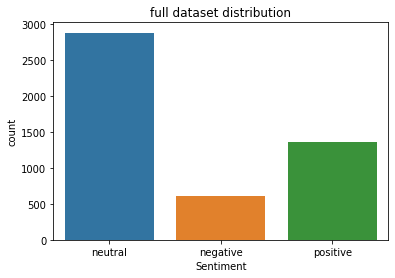

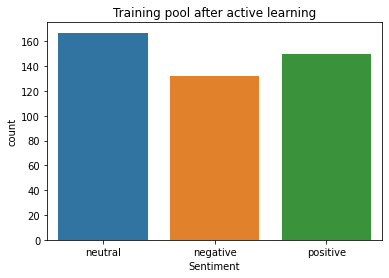

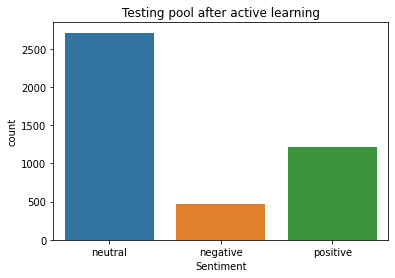

#################### 4 ###########################
189
(4208, 2) (638, 2)


  0%|          | 0/638 [00:00<?, ?it/s]

  0%|          | 0/638 [00:00<?, ?it/s]

  0%|          | 0/638 [00:00<?, ?it/s]

  0%|          | 0/638 [00:00<?, ?it/s]

  0%|          | 0/638 [00:00<?, ?it/s]

  0%|          | 0/638 [00:00<?, ?it/s]

  0%|          | 0/4208 [00:00<?, ?it/s]

  0%|          | 0/4208 [00:00<?, ?it/s]

  0%|          | 0/4208 [00:00<?, ?it/s]

  0%|          | 0/4208 [00:00<?, ?it/s]

  0%|          | 0/4208 [00:00<?, ?it/s]

  0%|          | 0/4208 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
13/13 [==============================] - 10s 785ms/step - loss: 0.4781 - balanced_accuracy: 0.8345 - val_loss: 0.5170 - val_balanced_accuracy: 0.8187
Epoch 2/10
13/13 [==============================] - 10s 788ms/step - loss: 0.1936 - balanced_accuracy: 0.9508 - val_loss: 0.5821 - val_balanced_accuracy: 0.8187
Epoch 3/10
13/13 [==============================] - 11s 841ms/step - loss: 0.1008 - balanced_accuracy: 0.9754 - val_loss: 0.6687 - val_balanced_accuracy: 0.8187
Epoch 4/10
13/13 [==============================] - 10s 780ms/step - loss: 0.0581 - balanced_accuracy: 0.9843 - val_loss: 0.6293 - val_balanced_accuracy: 0.8342
Epoch 5/10
13/13 [==============================] - 10s 795ms/step - loss: 0.0360 - balanced_accuracy: 0.9866 - val_loss: 0.6513 - val_balanced_accuracy: 0.8549
Epoch 6/10
13/13 [==============================] - 10s 785ms/step - loss: 0.0257 - balanced_accuracy: 0.9933 - val_loss: 0.6715 - val_balanced_accurac

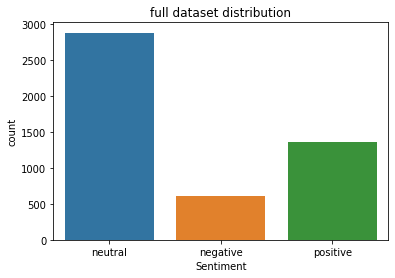

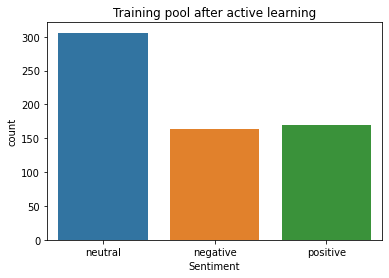

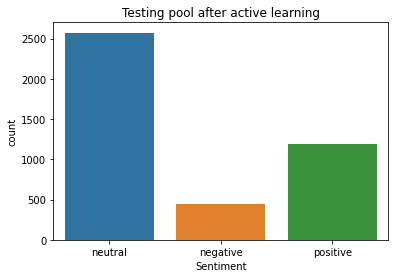

#################### 5 ###########################
9
(4199, 2) (647, 2)


  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/647 [00:00<?, ?it/s]

  0%|          | 0/4199 [00:00<?, ?it/s]

  0%|          | 0/4199 [00:00<?, ?it/s]

  0%|          | 0/4199 [00:00<?, ?it/s]

  0%|          | 0/4199 [00:00<?, ?it/s]

  0%|          | 0/4199 [00:00<?, ?it/s]

  0%|          | 0/4199 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
13/13 [==============================] - 10s 756ms/step - loss: 0.3047 - balanced_accuracy: 0.9007 - val_loss: 0.7768 - val_balanced_accuracy: 0.8316
Epoch 2/10
13/13 [==============================] - 10s 762ms/step - loss: 0.1313 - balanced_accuracy: 0.9713 - val_loss: 0.6193 - val_balanced_accuracy: 0.8520
Epoch 3/10
13/13 [==============================] - 11s 822ms/step - loss: 0.1098 - balanced_accuracy: 0.9779 - val_loss: 0.5912 - val_balanced_accuracy: 0.8520
Epoch 4/10
13/13 [==============================] - 10s 795ms/step - loss: 0.0746 - balanced_accuracy: 0.9801 - val_loss: 0.5392 - val_balanced_accuracy: 0.8776
Epoch 5/10
13/13 [==============================] - 10s 793ms/step - loss: 0.0595 - balanced_accuracy: 0.9868 - val_loss: 0.4950 - val_balanced_accuracy: 0.8622
Epoch 6/10
13/13 [==============================] - 10s 798ms/step - loss: 0.0404 - balanced_accuracy: 0.9912 - val_loss: 0.5804 - val_balanced_accurac

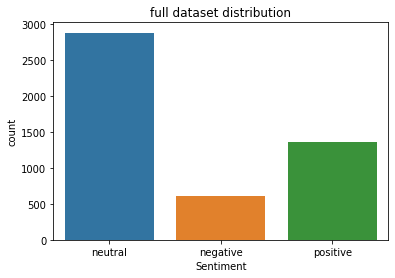

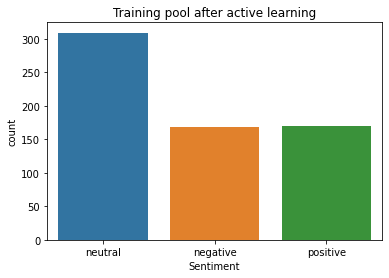

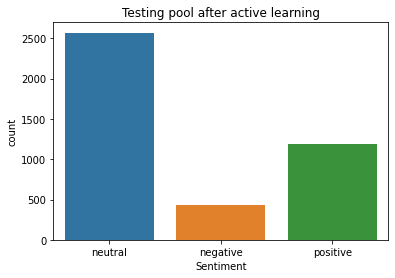

#################### 6 ###########################
16
(4183, 2) (663, 2)


  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/663 [00:00<?, ?it/s]

  0%|          | 0/4183 [00:00<?, ?it/s]

  0%|          | 0/4183 [00:00<?, ?it/s]

  0%|          | 0/4183 [00:00<?, ?it/s]

  0%|          | 0/4183 [00:00<?, ?it/s]

  0%|          | 0/4183 [00:00<?, ?it/s]

  0%|          | 0/4183 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
13/13 [==============================] - 11s 803ms/step - loss: 0.2545 - balanced_accuracy: 0.9161 - val_loss: 0.4729 - val_balanced_accuracy: 0.8800
Epoch 2/10
13/13 [==============================] - 10s 777ms/step - loss: 0.0870 - balanced_accuracy: 0.9828 - val_loss: 0.5559 - val_balanced_accuracy: 0.8750
Epoch 3/10
13/13 [==============================] - 10s 805ms/step - loss: 0.0482 - balanced_accuracy: 0.9849 - val_loss: 0.4091 - val_balanced_accuracy: 0.8750
Epoch 4/10
13/13 [==============================] - 11s 832ms/step - loss: 0.0152 - balanced_accuracy: 0.9957 - val_loss: 0.3879 - val_balanced_accuracy: 0.8650
Epoch 5/10
13/13 [==============================] - 11s 817ms/step - loss: 0.0066 - balanced_accuracy: 1.0000 - val_loss: 0.4302 - val_balanced_accuracy: 0.8750
Epoch 6/10
13/13 [==============================] - 10s 782ms/step - loss: 0.0060 - balanced_accuracy: 0.9978 - val_loss: 0.7115 - val_balanced_accurac

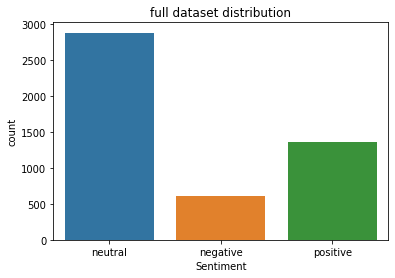

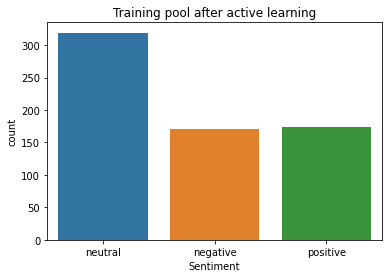

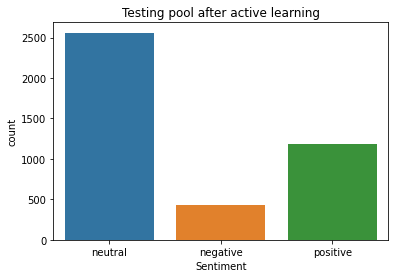

#################### 7 ###########################
4
(4179, 2) (667, 2)


  0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/667 [00:00<?, ?it/s]

  0%|          | 0/4179 [00:00<?, ?it/s]

  0%|          | 0/4179 [00:00<?, ?it/s]

  0%|          | 0/4179 [00:00<?, ?it/s]

  0%|          | 0/4179 [00:00<?, ?it/s]

  0%|          | 0/4179 [00:00<?, ?it/s]

  0%|          | 0/4179 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
13/13 [==============================] - 10s 795ms/step - loss: 0.2051 - balanced_accuracy: 0.9379 - val_loss: 0.6893 - val_balanced_accuracy: 0.8861
Epoch 2/10
13/13 [==============================] - 11s 821ms/step - loss: 0.0858 - balanced_accuracy: 0.9829 - val_loss: 0.5303 - val_balanced_accuracy: 0.8762
Epoch 3/10
13/13 [==============================] - 10s 812ms/step - loss: 0.0240 - balanced_accuracy: 0.9936 - val_loss: 0.3632 - val_balanced_accuracy: 0.9158
Epoch 4/10
13/13 [==============================] - 11s 825ms/step - loss: 0.0081 - balanced_accuracy: 0.9979 - val_loss: 0.5002 - val_balanced_accuracy: 0.9059
Epoch 5/10
13/13 [==============================] - 11s 825ms/step - loss: 0.0034 - balanced_accuracy: 1.0000 - val_loss: 0.6243 - val_balanced_accuracy: 0.9010
Epoch 6/10
13/13 [==============================] - 10s 804ms/step - loss: 0.0014 - balanced_accuracy: 1.0000 - val_loss: 0.6721 - val_balanced_accurac

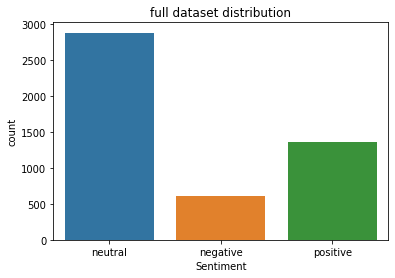

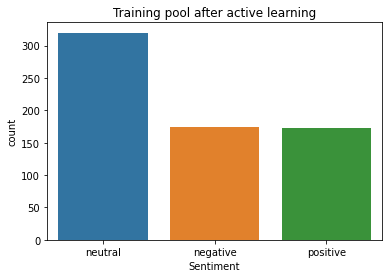

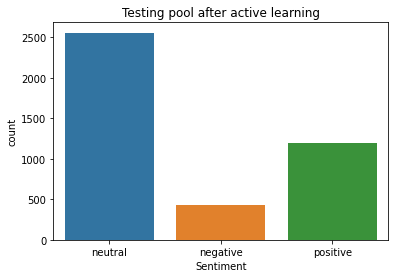

#################### 8 ###########################
26
(4153, 2) (693, 2)


  0%|          | 0/693 [00:00<?, ?it/s]

  0%|          | 0/693 [00:00<?, ?it/s]

  0%|          | 0/693 [00:00<?, ?it/s]

  0%|          | 0/693 [00:00<?, ?it/s]

  0%|          | 0/693 [00:00<?, ?it/s]

  0%|          | 0/693 [00:00<?, ?it/s]

  0%|          | 0/4153 [00:00<?, ?it/s]

  0%|          | 0/4153 [00:00<?, ?it/s]

  0%|          | 0/4153 [00:00<?, ?it/s]

  0%|          | 0/4153 [00:00<?, ?it/s]

  0%|          | 0/4153 [00:00<?, ?it/s]

  0%|          | 0/4153 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
14/14 [==============================] - 11s 783ms/step - loss: 0.2186 - balanced_accuracy: 0.9300 - val_loss: 0.3285 - val_balanced_accuracy: 0.9187
Epoch 2/10
14/14 [==============================] - 11s 764ms/step - loss: 0.0650 - balanced_accuracy: 0.9856 - val_loss: 0.9991 - val_balanced_accuracy: 0.8660
Epoch 3/10
14/14 [==============================] - 11s 788ms/step - loss: 0.0545 - balanced_accuracy: 0.9877 - val_loss: 0.4562 - val_balanced_accuracy: 0.8995
Epoch 4/10
14/14 [==============================] - 11s 807ms/step - loss: 0.0175 - balanced_accuracy: 0.9959 - val_loss: 0.7813 - val_balanced_accuracy: 0.8852
Epoch 5/10
14/14 [==============================] - 11s 779ms/step - loss: 0.0083 - balanced_accuracy: 0.9959 - val_loss: 0.8960 - val_balanced_accuracy: 0.8708
Epoch 6/10
14/14 [==============================] - 11s 768ms/step - loss: 0.0157 - balanced_accuracy: 0.9979 - val_loss: 0.9212 - val_balanced_accurac

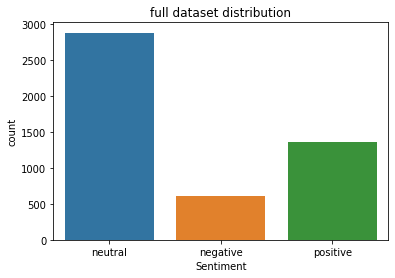

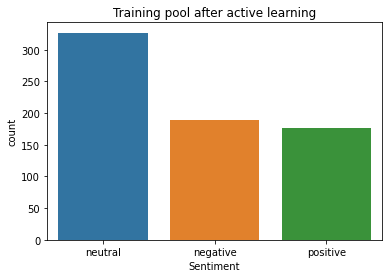

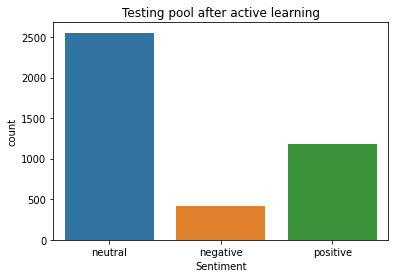

#################### 9 ###########################
2
(4151, 2) (695, 2)


  0%|          | 0/695 [00:00<?, ?it/s]

  0%|          | 0/695 [00:00<?, ?it/s]

  0%|          | 0/695 [00:00<?, ?it/s]

  0%|          | 0/695 [00:00<?, ?it/s]

  0%|          | 0/695 [00:00<?, ?it/s]

  0%|          | 0/695 [00:00<?, ?it/s]

  0%|          | 0/4151 [00:00<?, ?it/s]

  0%|          | 0/4151 [00:00<?, ?it/s]

  0%|          | 0/4151 [00:00<?, ?it/s]

  0%|          | 0/4151 [00:00<?, ?it/s]

  0%|          | 0/4151 [00:00<?, ?it/s]

  0%|          | 0/4151 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
14/14 [==============================] - 11s 771ms/step - loss: 0.2707 - balanced_accuracy: 0.9179 - val_loss: 0.7420 - val_balanced_accuracy: 0.8667
Epoch 2/10
14/14 [==============================] - 11s 818ms/step - loss: 0.0280 - balanced_accuracy: 0.9959 - val_loss: 0.8499 - val_balanced_accuracy: 0.8571
Epoch 3/10
14/14 [==============================] - 11s 795ms/step - loss: 0.0382 - balanced_accuracy: 0.9877 - val_loss: 0.8695 - val_balanced_accuracy: 0.8810
Epoch 4/10
14/14 [==============================] - 11s 779ms/step - loss: 0.0142 - balanced_accuracy: 0.9959 - val_loss: 0.5543 - val_balanced_accuracy: 0.9048
Epoch 5/10
14/14 [==============================] - 11s 778ms/step - loss: 0.0025 - balanced_accuracy: 1.0000 - val_loss: 0.6201 - val_balanced_accuracy: 0.9095
Epoch 6/10
14/14 [==============================] - 11s 771ms/step - loss: 0.0014 - balanced_accuracy: 1.0000 - val_loss: 0.6817 - val_balanced_accurac

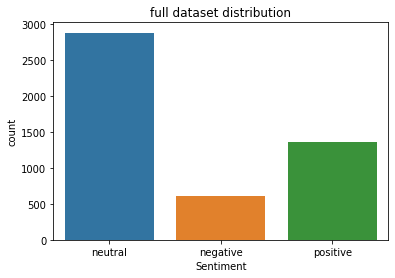

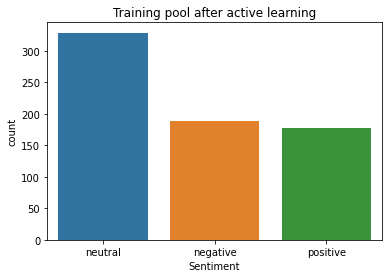

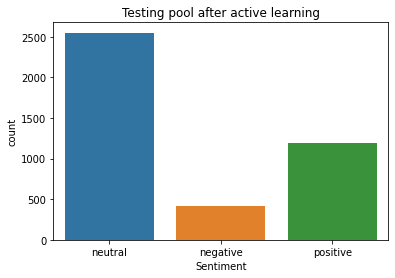

#################### 10 ###########################
4
(4147, 2) (699, 2)


  0%|          | 0/699 [00:00<?, ?it/s]

  0%|          | 0/699 [00:00<?, ?it/s]

  0%|          | 0/699 [00:00<?, ?it/s]

  0%|          | 0/699 [00:00<?, ?it/s]

  0%|          | 0/699 [00:00<?, ?it/s]

  0%|          | 0/699 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
14/14 [==============================] - 11s 789ms/step - loss: 0.1964 - balanced_accuracy: 0.9449 - val_loss: 1.0919 - val_balanced_accuracy: 0.8626
Epoch 2/10
14/14 [==============================] - 11s 825ms/step - loss: 0.0655 - balanced_accuracy: 0.9837 - val_loss: 0.5223 - val_balanced_accuracy: 0.9052
Epoch 3/10
14/14 [==============================] - 11s 804ms/step - loss: 0.0260 - balanced_accuracy: 0.9939 - val_loss: 0.8001 - val_balanced_accuracy: 0.8815
Epoch 4/10
14/14 [==============================] - 11s 767ms/step - loss: 0.0125 - balanced_accuracy: 1.0000 - val_loss: 0.7849 - val_balanced_accuracy: 0.8815
Epoch 5/10
14/14 [==============================] - 11s 804ms/step - loss: 0.0020 - balanced_accuracy: 1.0000 - val_loss: 0.7074 - val_balanced_accuracy: 0.8910
Epoch 6/10
14/14 [==============================] - 11s 760ms/step - loss: 0.0014 - balanced_accuracy: 1.0000 - val_loss: 0.6952 - val_balanced_accurac

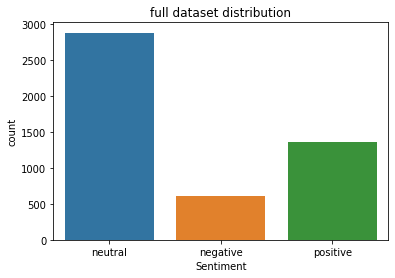

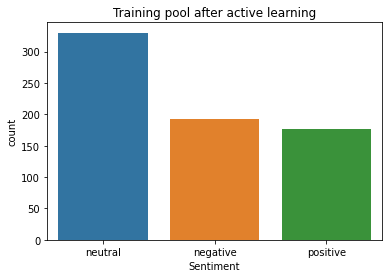

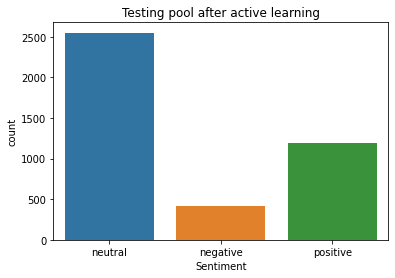

#################### 11 ###########################
15
(4132, 2) (714, 2)


  0%|          | 0/714 [00:00<?, ?it/s]

  0%|          | 0/714 [00:00<?, ?it/s]

  0%|          | 0/714 [00:00<?, ?it/s]

  0%|          | 0/714 [00:00<?, ?it/s]

  0%|          | 0/714 [00:00<?, ?it/s]

  0%|          | 0/714 [00:00<?, ?it/s]

  0%|          | 0/4132 [00:00<?, ?it/s]

  0%|          | 0/4132 [00:00<?, ?it/s]

  0%|          | 0/4132 [00:00<?, ?it/s]

  0%|          | 0/4132 [00:00<?, ?it/s]

  0%|          | 0/4132 [00:00<?, ?it/s]

  0%|          | 0/4132 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
14/14 [==============================] - 11s 791ms/step - loss: 0.2207 - balanced_accuracy: 0.9280 - val_loss: 0.7259 - val_balanced_accuracy: 0.8565
Epoch 2/10
14/14 [==============================] - 11s 775ms/step - loss: 0.1434 - balanced_accuracy: 0.9720 - val_loss: 0.5315 - val_balanced_accuracy: 0.8843
Epoch 3/10
14/14 [==============================] - 11s 801ms/step - loss: 0.0758 - balanced_accuracy: 0.9820 - val_loss: 0.5943 - val_balanced_accuracy: 0.8750
Epoch 4/10
14/14 [==============================] - 11s 817ms/step - loss: 0.0293 - balanced_accuracy: 0.9940 - val_loss: 0.5737 - val_balanced_accuracy: 0.8843
Epoch 5/10
14/14 [==============================] - 11s 817ms/step - loss: 0.0234 - balanced_accuracy: 0.9960 - val_loss: 0.6722 - val_balanced_accuracy: 0.8843
Epoch 6/10
14/14 [==============================] - 11s 790ms/step - loss: 0.0206 - balanced_accuracy: 0.9960 - val_loss: 0.6620 - val_balanced_accurac

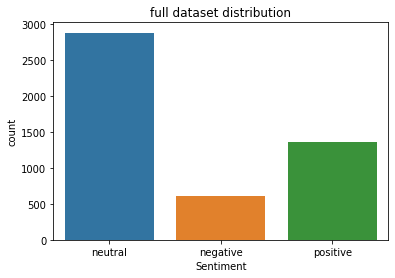

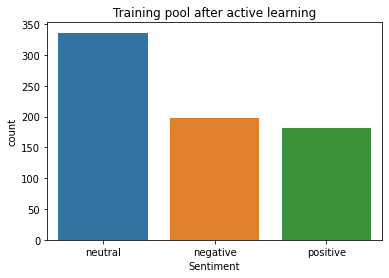

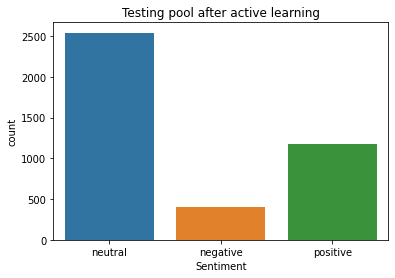

#################### 12 ###########################
3
(4129, 2) (717, 2)


  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/717 [00:00<?, ?it/s]

  0%|          | 0/4129 [00:00<?, ?it/s]

  0%|          | 0/4129 [00:00<?, ?it/s]

  0%|          | 0/4129 [00:00<?, ?it/s]

  0%|          | 0/4129 [00:00<?, ?it/s]

  0%|          | 0/4129 [00:00<?, ?it/s]

  0%|          | 0/4129 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
14/14 [==============================] - 11s 771ms/step - loss: 0.2656 - balanced_accuracy: 0.9203 - val_loss: 0.9073 - val_balanced_accuracy: 0.8802
Epoch 2/10
14/14 [==============================] - 11s 788ms/step - loss: 0.0785 - balanced_accuracy: 0.9841 - val_loss: 0.5198 - val_balanced_accuracy: 0.9032
Epoch 3/10
14/14 [==============================] - 11s 822ms/step - loss: 0.0484 - balanced_accuracy: 0.9900 - val_loss: 0.4478 - val_balanced_accuracy: 0.9171
Epoch 4/10
14/14 [==============================] - 11s 813ms/step - loss: 0.0310 - balanced_accuracy: 0.9940 - val_loss: 0.3791 - val_balanced_accuracy: 0.9217
Epoch 5/10
14/14 [==============================] - 11s 819ms/step - loss: 0.0198 - balanced_accuracy: 0.9960 - val_loss: 0.5307 - val_balanced_accuracy: 0.9171
Epoch 6/10
14/14 [==============================] - 11s 812ms/step - loss: 0.0151 - balanced_accuracy: 0.9980 - val_loss: 0.6667 - val_balanced_accurac

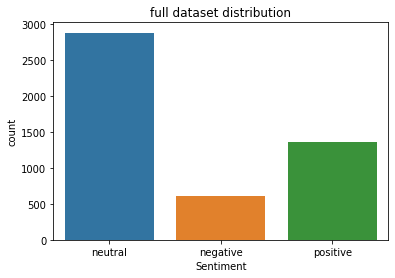

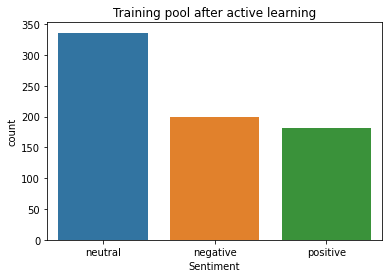

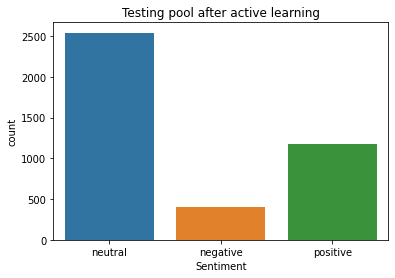

#################### 13 ###########################
13
(4116, 2) (730, 2)


  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/730 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
15/15 [==============================] - 11s 752ms/step - loss: 0.2145 - balanced_accuracy: 0.9277 - val_loss: 0.4185 - val_balanced_accuracy: 0.9136
Epoch 2/10
15/15 [==============================] - 11s 759ms/step - loss: 0.1174 - balanced_accuracy: 0.9805 - val_loss: 0.3868 - val_balanced_accuracy: 0.9273
Epoch 3/10
15/15 [==============================] - 12s 787ms/step - loss: 0.0636 - balanced_accuracy: 0.9863 - val_loss: 0.4613 - val_balanced_accuracy: 0.9136
Epoch 4/10
15/15 [==============================] - 12s 794ms/step - loss: 0.0532 - balanced_accuracy: 0.9922 - val_loss: 0.4296 - val_balanced_accuracy: 0.9227
Epoch 5/10
15/15 [==============================] - 12s 775ms/step - loss: 0.0513 - balanced_accuracy: 0.9922 - val_loss: 0.4207 - val_balanced_accuracy: 0.9182
Epoch 6/10
15/15 [==============================] - 12s 809ms/step - loss: 0.0378 - balanced_accuracy: 0.9941 - val_loss: 0.4100 - val_balanced_accurac

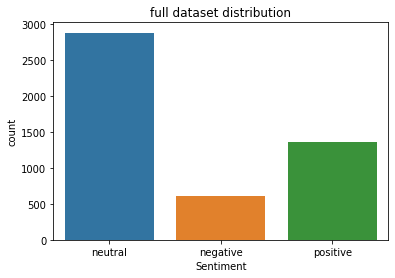

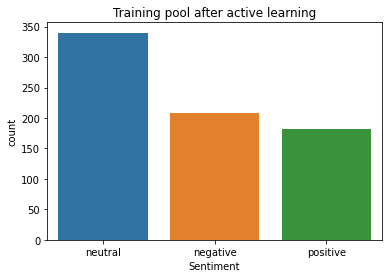

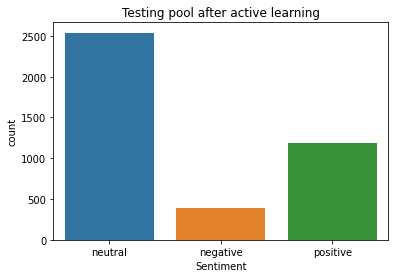

#################### 14 ###########################
5
(4111, 2) (735, 2)


  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/735 [00:00<?, ?it/s]

  0%|          | 0/4111 [00:00<?, ?it/s]

  0%|          | 0/4111 [00:00<?, ?it/s]

  0%|          | 0/4111 [00:00<?, ?it/s]

  0%|          | 0/4111 [00:00<?, ?it/s]

  0%|          | 0/4111 [00:00<?, ?it/s]

  0%|          | 0/4111 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
15/15 [==============================] - 12s 757ms/step - loss: 0.2719 - balanced_accuracy: 0.9223 - val_loss: 0.4322 - val_balanced_accuracy: 0.9189
Epoch 2/10
15/15 [==============================] - 11s 761ms/step - loss: 0.0921 - balanced_accuracy: 0.9786 - val_loss: 0.3768 - val_balanced_accuracy: 0.9099
Epoch 3/10
15/15 [==============================] - 12s 783ms/step - loss: 0.0510 - balanced_accuracy: 0.9922 - val_loss: 0.4509 - val_balanced_accuracy: 0.9189
Epoch 4/10
15/15 [==============================] - 12s 782ms/step - loss: 0.0347 - balanced_accuracy: 0.9942 - val_loss: 0.4861 - val_balanced_accuracy: 0.9189
Epoch 5/10
15/15 [==============================] - 12s 785ms/step - loss: 0.0302 - balanced_accuracy: 0.9942 - val_loss: 0.5031 - val_balanced_accuracy: 0.9279
Epoch 6/10
15/15 [==============================] - 11s 756ms/step - loss: 0.0167 - balanced_accuracy: 0.9981 - val_loss: 0.5359 - val_balanced_accurac

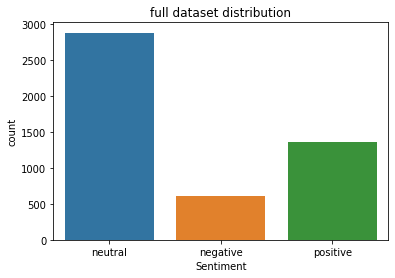

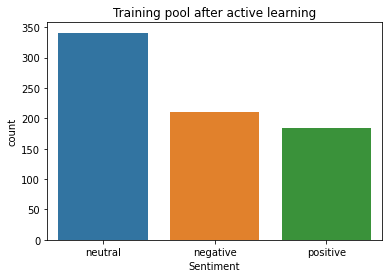

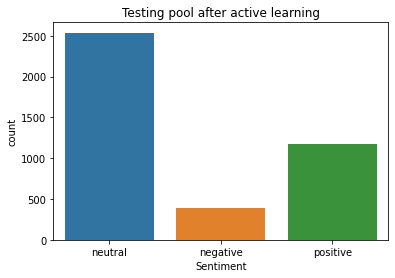

#################### 15 ###########################
7
(4104, 2) (742, 2)


  0%|          | 0/742 [00:00<?, ?it/s]

  0%|          | 0/742 [00:00<?, ?it/s]

  0%|          | 0/742 [00:00<?, ?it/s]

  0%|          | 0/742 [00:00<?, ?it/s]

  0%|          | 0/742 [00:00<?, ?it/s]

  0%|          | 0/742 [00:00<?, ?it/s]

  0%|          | 0/4104 [00:00<?, ?it/s]

  0%|          | 0/4104 [00:00<?, ?it/s]

  0%|          | 0/4104 [00:00<?, ?it/s]

  0%|          | 0/4104 [00:00<?, ?it/s]

  0%|          | 0/4104 [00:00<?, ?it/s]

  0%|          | 0/4104 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
15/15 [==============================] - 12s 757ms/step - loss: 0.2620 - balanced_accuracy: 0.9019 - val_loss: 0.6562 - val_balanced_accuracy: 0.8973
Epoch 2/10
15/15 [==============================] - 13s 873ms/step - loss: 0.0523 - balanced_accuracy: 0.9885 - val_loss: 0.4339 - val_balanced_accuracy: 0.9196
Epoch 3/10
15/15 [==============================] - 13s 875ms/step - loss: 0.0954 - balanced_accuracy: 0.9846 - val_loss: 0.4130 - val_balanced_accuracy: 0.9241
Epoch 4/10
15/15 [==============================] - 12s 780ms/step - loss: 0.0452 - balanced_accuracy: 0.9923 - val_loss: 0.3421 - val_balanced_accuracy: 0.9286
Epoch 5/10
15/15 [==============================] - 13s 861ms/step - loss: 0.0154 - balanced_accuracy: 0.9981 - val_loss: 0.4277 - val_balanced_accuracy: 0.9196
Epoch 6/10
15/15 [==============================] - 11s 759ms/step - loss: 0.0269 - balanced_accuracy: 0.9962 - val_loss: 0.4485 - val_balanced_accurac

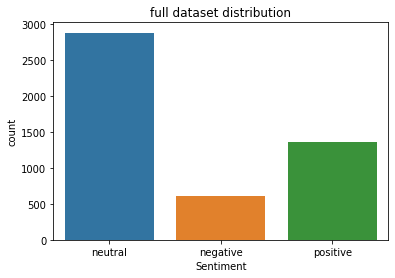

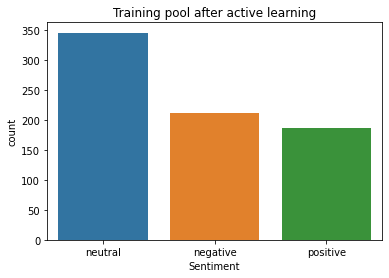

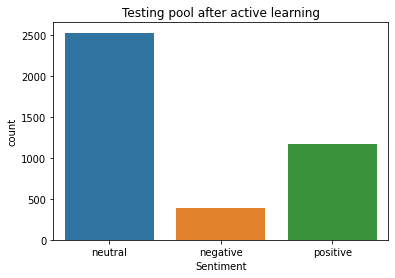

#################### 16 ###########################
8
(4096, 2) (750, 2)


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
15/15 [==============================] - 12s 775ms/step - loss: 0.1489 - balanced_accuracy: 0.9601 - val_loss: 0.4548 - val_balanced_accuracy: 0.9336
Epoch 2/10
15/15 [==============================] - 12s 809ms/step - loss: 0.0317 - balanced_accuracy: 0.9943 - val_loss: 0.4123 - val_balanced_accuracy: 0.9292
Epoch 3/10
15/15 [==============================] - 12s 800ms/step - loss: 0.0175 - balanced_accuracy: 0.9962 - val_loss: 0.4582 - val_balanced_accuracy: 0.9292
Epoch 4/10
15/15 [==============================] - 13s 871ms/step - loss: 0.0136 - balanced_accuracy: 0.9981 - val_loss: 0.4970 - val_balanced_accuracy: 0.9381
Epoch 5/10
15/15 [==============================] - 11s 761ms/step - loss: 0.0014 - balanced_accuracy: 1.0000 - val_loss: 0.3766 - val_balanced_accuracy: 0.9336
Epoch 6/10
15/15 [==============================] - 11s 759ms/step - loss: 0.0037 - balanced_accuracy: 0.9981 - val_loss: 0.4320 - val_balanced_accurac

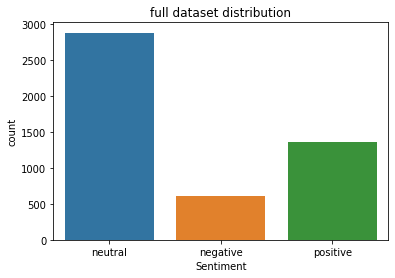

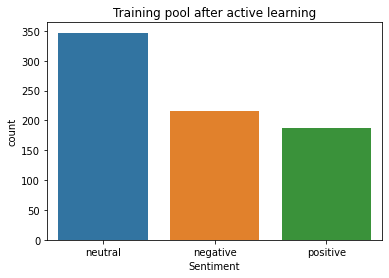

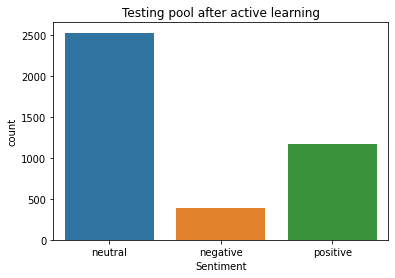

#################### 17 ###########################
10
(4086, 2) (760, 2)


  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/4086 [00:00<?, ?it/s]

  0%|          | 0/4086 [00:00<?, ?it/s]

  0%|          | 0/4086 [00:00<?, ?it/s]

  0%|          | 0/4086 [00:00<?, ?it/s]

  0%|          | 0/4086 [00:00<?, ?it/s]

  0%|          | 0/4086 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
15/15 [==============================] - 12s 772ms/step - loss: 0.3115 - balanced_accuracy: 0.8931 - val_loss: 0.4336 - val_balanced_accuracy: 0.8952
Epoch 2/10
15/15 [==============================] - 11s 768ms/step - loss: 0.0217 - balanced_accuracy: 0.9962 - val_loss: 0.4995 - val_balanced_accuracy: 0.9127
Epoch 3/10
15/15 [==============================] - 12s 802ms/step - loss: 0.0282 - balanced_accuracy: 0.9962 - val_loss: 0.3784 - val_balanced_accuracy: 0.9301
Epoch 4/10
15/15 [==============================] - 13s 876ms/step - loss: 0.0022 - balanced_accuracy: 1.0000 - val_loss: 0.4315 - val_balanced_accuracy: 0.9258
Epoch 5/10
15/15 [==============================] - 12s 781ms/step - loss: 0.0015 - balanced_accuracy: 1.0000 - val_loss: 0.4555 - val_balanced_accuracy: 0.9214
Epoch 6/10
15/15 [==============================] - 12s 793ms/step - loss: 0.0011 - balanced_accuracy: 1.0000 - val_loss: 0.4683 - val_balanced_accurac

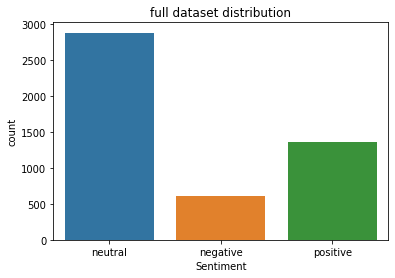

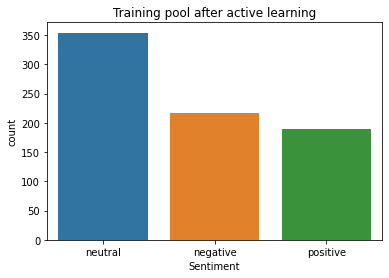

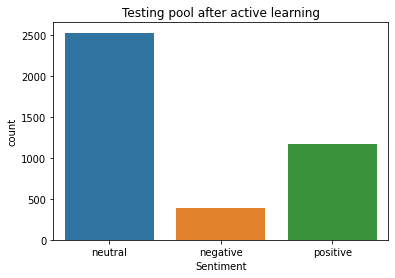

#################### 18 ###########################
1
(4085, 2) (761, 2)


  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/761 [00:00<?, ?it/s]

  0%|          | 0/4085 [00:00<?, ?it/s]

  0%|          | 0/4085 [00:00<?, ?it/s]

  0%|          | 0/4085 [00:00<?, ?it/s]

  0%|          | 0/4085 [00:00<?, ?it/s]

  0%|          | 0/4085 [00:00<?, ?it/s]

  0%|          | 0/4085 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
15/15 [==============================] - 12s 769ms/step - loss: 0.1555 - balanced_accuracy: 0.9362 - val_loss: 0.4623 - val_balanced_accuracy: 0.9261
Epoch 2/10
15/15 [==============================] - 13s 890ms/step - loss: 0.0540 - balanced_accuracy: 0.9925 - val_loss: 0.5697 - val_balanced_accuracy: 0.9130
Epoch 3/10
15/15 [==============================] - 12s 800ms/step - loss: 0.0399 - balanced_accuracy: 0.9925 - val_loss: 0.4760 - val_balanced_accuracy: 0.9304
Epoch 4/10
15/15 [==============================] - 13s 890ms/step - loss: 0.0221 - balanced_accuracy: 0.9962 - val_loss: 0.4257 - val_balanced_accuracy: 0.9217
Epoch 5/10
15/15 [==============================] - 12s 770ms/step - loss: 0.0278 - balanced_accuracy: 0.9944 - val_loss: 0.4681 - val_balanced_accuracy: 0.9130
Epoch 6/10
15/15 [==============================] - 13s 854ms/step - loss: 0.0201 - balanced_accuracy: 0.9962 - val_loss: 0.4271 - val_balanced_accurac

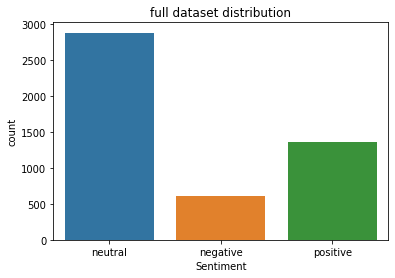

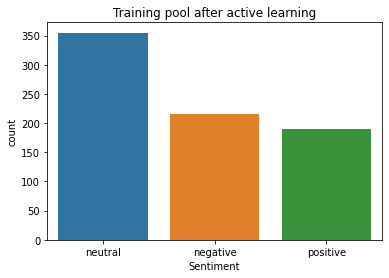

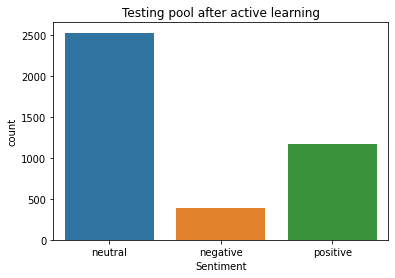

#################### 19 ###########################
45
(4040, 2) (806, 2)


  0%|          | 0/806 [00:00<?, ?it/s]

  0%|          | 0/806 [00:00<?, ?it/s]

  0%|          | 0/806 [00:00<?, ?it/s]

  0%|          | 0/806 [00:00<?, ?it/s]

  0%|          | 0/806 [00:00<?, ?it/s]

  0%|          | 0/806 [00:00<?, ?it/s]

  0%|          | 0/4040 [00:00<?, ?it/s]

  0%|          | 0/4040 [00:00<?, ?it/s]

  0%|          | 0/4040 [00:00<?, ?it/s]

  0%|          | 0/4040 [00:00<?, ?it/s]

  0%|          | 0/4040 [00:00<?, ?it/s]

  0%|          | 0/4040 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
16/16 [==============================] - 12s 761ms/step - loss: 0.1832 - balanced_accuracy: 0.9469 - val_loss: 0.4232 - val_balanced_accuracy: 0.9218
Epoch 2/10
16/16 [==============================] - 14s 876ms/step - loss: 0.0787 - balanced_accuracy: 0.9858 - val_loss: 0.5154 - val_balanced_accuracy: 0.9095
Epoch 3/10
16/16 [==============================] - 12s 778ms/step - loss: 0.0485 - balanced_accuracy: 0.9876 - val_loss: 0.3828 - val_balanced_accuracy: 0.9136
Epoch 4/10
16/16 [==============================] - 14s 884ms/step - loss: 0.0387 - balanced_accuracy: 0.9912 - val_loss: 0.4116 - val_balanced_accuracy: 0.9177
Epoch 5/10
16/16 [==============================] - 12s 768ms/step - loss: 0.0156 - balanced_accuracy: 0.9965 - val_loss: 0.4415 - val_balanced_accuracy: 0.9136
Epoch 6/10
16/16 [==============================] - 12s 769ms/step - loss: 0.0039 - balanced_accuracy: 1.0000 - val_loss: 0.4760 - val_balanced_accurac

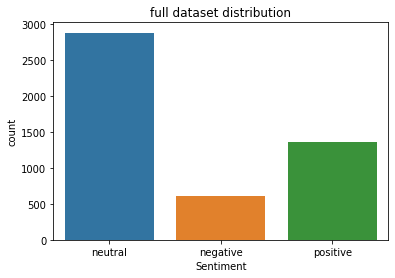

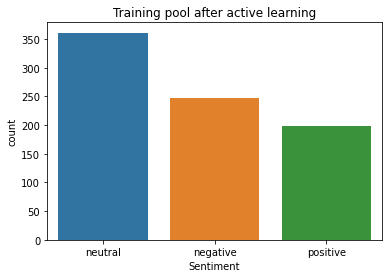

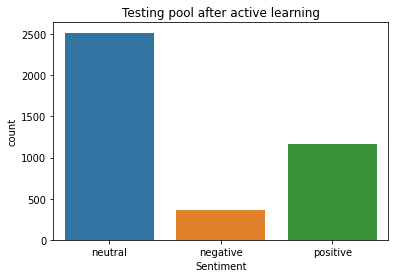

#################### 20 ###########################
5
(4035, 2) (811, 2)


  0%|          | 0/811 [00:00<?, ?it/s]

  0%|          | 0/811 [00:00<?, ?it/s]

  0%|          | 0/811 [00:00<?, ?it/s]

  0%|          | 0/811 [00:00<?, ?it/s]

  0%|          | 0/811 [00:00<?, ?it/s]

  0%|          | 0/811 [00:00<?, ?it/s]

  0%|          | 0/4035 [00:00<?, ?it/s]

  0%|          | 0/4035 [00:00<?, ?it/s]

  0%|          | 0/4035 [00:00<?, ?it/s]

  0%|          | 0/4035 [00:00<?, ?it/s]

  0%|          | 0/4035 [00:00<?, ?it/s]

  0%|          | 0/4035 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
16/16 [==============================] - 13s 789ms/step - loss: 0.2092 - balanced_accuracy: 0.9472 - val_loss: 0.5160 - val_balanced_accuracy: 0.9184
Epoch 2/10
16/16 [==============================] - 14s 857ms/step - loss: 0.0566 - balanced_accuracy: 0.9912 - val_loss: 0.4702 - val_balanced_accuracy: 0.9184
Epoch 3/10
16/16 [==============================] - 14s 887ms/step - loss: 0.0280 - balanced_accuracy: 0.9947 - val_loss: 0.5329 - val_balanced_accuracy: 0.8939
Epoch 4/10
16/16 [==============================] - 14s 868ms/step - loss: 0.0293 - balanced_accuracy: 0.9930 - val_loss: 0.5131 - val_balanced_accuracy: 0.9102
Epoch 5/10
16/16 [==============================] - 12s 769ms/step - loss: 0.0154 - balanced_accuracy: 0.9965 - val_loss: 0.5104 - val_balanced_accuracy: 0.9102
Epoch 6/10
16/16 [==============================] - 12s 774ms/step - loss: 0.0103 - balanced_accuracy: 0.9982 - val_loss: 0.5833 - val_balanced_accurac

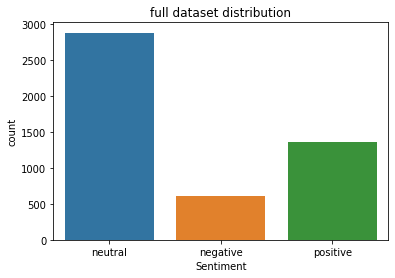

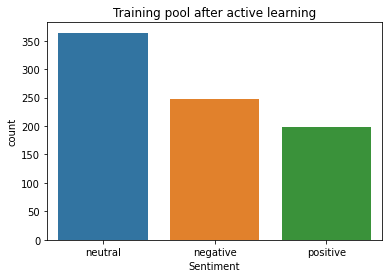

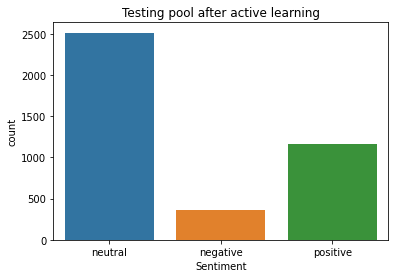

#################### 21 ###########################
12
(4023, 2) (823, 2)


  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/823 [00:00<?, ?it/s]

  0%|          | 0/4023 [00:00<?, ?it/s]

  0%|          | 0/4023 [00:00<?, ?it/s]

  0%|          | 0/4023 [00:00<?, ?it/s]

  0%|          | 0/4023 [00:00<?, ?it/s]

  0%|          | 0/4023 [00:00<?, ?it/s]

  0%|          | 0/4023 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
17/17 [==============================] - 13s 756ms/step - loss: 0.2579 - balanced_accuracy: 0.9220 - val_loss: 0.5018 - val_balanced_accuracy: 0.8871
Epoch 2/10
17/17 [==============================] - 13s 773ms/step - loss: 0.0596 - balanced_accuracy: 0.9879 - val_loss: 0.4585 - val_balanced_accuracy: 0.9032
Epoch 3/10
17/17 [==============================] - 14s 857ms/step - loss: 0.0256 - balanced_accuracy: 0.9948 - val_loss: 0.5856 - val_balanced_accuracy: 0.8952
Epoch 4/10
17/17 [==============================] - 14s 847ms/step - loss: 0.0124 - balanced_accuracy: 0.9948 - val_loss: 0.5636 - val_balanced_accuracy: 0.9032
Epoch 5/10
17/17 [==============================] - 13s 759ms/step - loss: 0.0016 - balanced_accuracy: 1.0000 - val_loss: 0.6426 - val_balanced_accuracy: 0.9032
Epoch 6/10
17/17 [==============================] - 13s 744ms/step - loss: 0.0114 - balanced_accuracy: 0.9983 - val_loss: 0.6549 - val_balanced_accurac

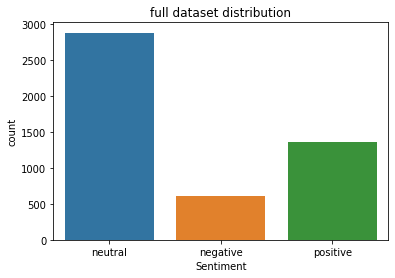

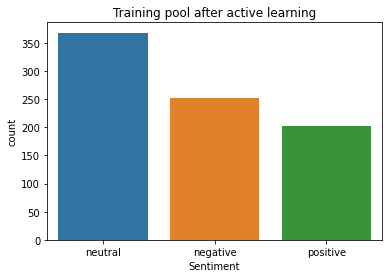

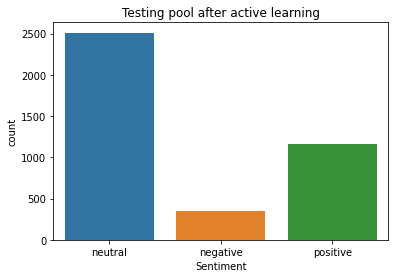

#################### 22 ###########################
3
(4020, 2) (826, 2)


  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/826 [00:00<?, ?it/s]

  0%|          | 0/4020 [00:00<?, ?it/s]

  0%|          | 0/4020 [00:00<?, ?it/s]

  0%|          | 0/4020 [00:00<?, ?it/s]

  0%|          | 0/4020 [00:00<?, ?it/s]

  0%|          | 0/4020 [00:00<?, ?it/s]

  0%|          | 0/4020 [00:00<?, ?it/s]

The number of words in string are : 115 565
Epoch 1/10
17/17 [==============================] - 13s 743ms/step - loss: 0.1703 - balanced_accuracy: 0.9361 - val_loss: 0.7556 - val_balanced_accuracy: 0.8755
Epoch 2/10
17/17 [==============================] - 14s 834ms/step - loss: 0.0705 - balanced_accuracy: 0.9879 - val_loss: 0.5331 - val_balanced_accuracy: 0.9076
Epoch 3/10
17/17 [==============================] - 14s 846ms/step - loss: 0.0519 - balanced_accuracy: 0.9931 - val_loss: 0.4623 - val_balanced_accuracy: 0.9076
Epoch 4/10
17/17 [==============================] - 13s 763ms/step - loss: 0.0387 - balanced_accuracy: 0.9948 - val_loss: 0.4168 - val_balanced_accuracy: 0.9197
Epoch 5/10
17/17 [==============================] - 14s 856ms/step - loss: 0.0305 - balanced_accuracy: 0.9931 - val_loss: 0.4226 - val_balanced_accuracy: 0.9076
Epoch 6/10
17/17 [==============================] - 13s 777ms/step - loss: 0.0307 - balanced_accuracy: 0.9931 - val_loss: 0.4427 - val_balanced_accurac

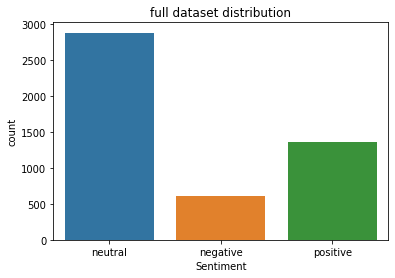

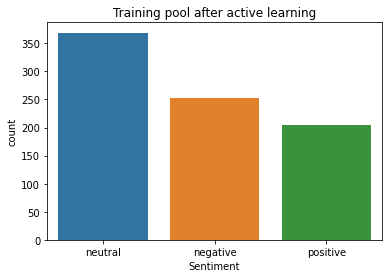

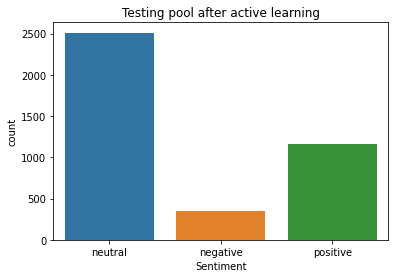

#################### 23 ###########################
2547


IndexError: single positional indexer is out-of-bounds

In [6]:
for k in range(100):
    print('####################',k+1,"###########################")
    ine,_=predicted_raw.shape
    lis=[]
    lis3=[]
    df_test=indexGenerator(df_test)
    df_train=indexGenerator(df_train)
    for i in range(ine):
        if (maxConflictFinder(predicted_raw[i]) != None):
            lis3.append(i)
    print(len(lis3))        
    df_test=indexGenerator(df_test)
    df_train=indexGenerator(df_train)
    df_test,df_train=dataTx_trial(lis3,df_test,df_train)
    print(df_test.shape,df_train.shape)
    df_test=indexGenerator(df_test)
    df_train=indexGenerator(df_train)

    df_cleaned_train_20 = text_preprocessing(df_train,'Input')
    df_cleaned_test_20 = text_preprocessing(df_test,'Input')
    train20_df = df_cleaned_train_20.copy()
    test20_df = df_cleaned_test_20.copy()
    train20_df['num_words'] = train20_df.Input.apply(lambda x:len(x.split()))
    test20_df['num_words'] = test20_df.Input.apply(lambda x:len(x.split()))
    train20_df['Sentiment'] = train20_df.Sentiment.astype('category')
    test20_df['Sentiment'] = test20_df.Sentiment.astype('category')
    train20_df['Sentiment']  =  train20_df.Sentiment.cat.codes
    test20_df['Sentiment']  =  test20_df.Sentiment.cat.codes

    from sklearn.model_selection import train_test_split
    data_train,data_test = train_test_split(train20_df, test_size = 0.30, random_state = 42, stratify = train20_df.Sentiment)

    surprise_string ='i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies '
    len(surprise_string)
    res = len(surprise_string.split())
    print("The number of words in string are : " + str(res),len(surprise_string) )
    data_test = data_test.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
    data_train = data_train.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
    data_val = test20_df.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
    
    x_train = tokenizer(
        text=data_train.Input.tolist(),
        add_special_tokens=True,
        max_length=70,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)

    x_test = tokenizer(
        text=data_test.Input.tolist(),
        add_special_tokens=True,
        max_length=70,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)

    x_val = tokenizer(
        text=data_val.Input.tolist(),
        add_special_tokens=True,
        max_length=70,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True)
    
    max_len = 70
    import tensorflow as tf
    from tensorflow.keras.layers import Input, Dense

    input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
    out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
    out = Dense(128, activation='relu')(out)
    out = tf.keras.layers.Dropout(0.1)(out)
    out = Dense(32,activation = 'relu')(out)

    y = Dense(3,activation = 'sigmoid')(out)
    
    model5 = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
    model5.layers[2].trainable = True
    optimizer = Adam(
        learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0)
    loss =CategoricalCrossentropy(from_logits = True)
    metric = CategoricalAccuracy('balanced_accuracy'),
    model5.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = metric)
    tf.config.experimental_run_functions_eagerly(True)
    tf.config.run_functions_eagerly(True)

    train_history = model5.fit(
        x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
        y = to_categorical(data_train.Sentiment),
        validation_data = (
            {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.Sentiment)
            ),
       epochs=10,
       batch_size=36
       )
    predicted_raw = model5.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})
    predicted_raw = model5.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})
    y_predicted = np.argmax(predicted_raw, axis = 1)
    print(classification_report(data_val.Sentiment, y_predicted))
    print(confusion_matrix(data_val.Sentiment,y_predicted))
    cf_matrix=confusion_matrix(data_val.Sentiment,y_predicted)
    sns.countplot(x="Sentiment",data=df_full)
    plt.title("full dataset distribution")
    plt.show()
    sns.countplot(x="Sentiment",data=df_train)
    plt.title("Training pool after active learning")
    plt.show()
    sns.countplot(x="Sentiment",data=df_test)
    plt.title("Testing pool after active learning")
    plt.show()
    if(len(lis3)==0):
        break


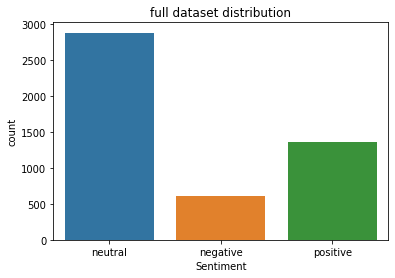

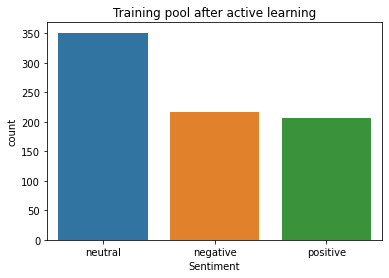

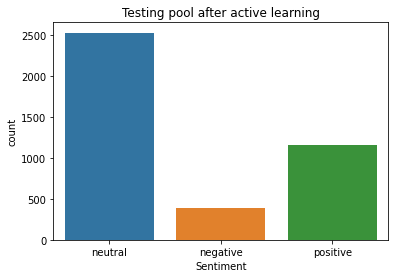

In [17]:
sns.countplot(x="Sentiment",data=df_full)
plt.title("full dataset distribution")
plt.show()

sns.countplot(x="Sentiment",data=df_train)
plt.title("Training pool after active learning")
plt.show()

sns.countplot(x="Sentiment",data=df_test)
plt.title("Testing pool after active learning")
plt.show()

In [ ]:
# for k in range(100):
#     print('####################',k+1,"###########################")
#     df_cleaned_train_20 = text_preprocessing(df_train,'Input')
#     df_cleaned_test_20 = text_preprocessing(df_test,'Input')
#     train20_df = df_cleaned_train_20.copy()
#     test20_df = df_cleaned_test_20.copy()
#     train20_df['num_words'] = train20_df.Input.apply(lambda x:len(x.split()))
#     test20_df['num_words'] = test20_df.Input.apply(lambda x:len(x.split()))
#     train20_df['Sentiment'] = train20_df.Sentiment.astype('category')
#     test20_df['Sentiment'] = test20_df.Sentiment.astype('category')
#     train20_df['Sentiment']  =  train20_df.Sentiment.cat.codes
#     test20_df['Sentiment']  =  test20_df.Sentiment.cat.codes
#     from sklearn.model_selection import train_test_split
#     data_train,data_test = train_test_split(train20_df, test_size = 0.30, random_state = 42, stratify = train20_df.Sentiment)
#     surprise_string ='i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies '
#     len(surprise_string)
#     res = len(surprise_string.split())
#     print("The number of words in string are : " + str(res),len(surprise_string) )
#     data_test = data_test.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
#     data_train = data_train.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
#     data_val = test20_df.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
    
#     x_train = tokenizer(
#         text=data_train.Input.tolist(),
#         add_special_tokens=True,
#         max_length=70,
#         truncation=True,
#         padding=True, 
#         return_tensors='tf',
#         return_token_type_ids = False,
#         return_attention_mask = True,
#         verbose = True)
    
#     x_test = tokenizer(
#         text=data_test.Input.tolist(),
#         add_special_tokens=True,
#         max_length=70,
#         truncation=True,
#         padding=True, 
#         return_tensors='tf',
#         return_token_type_ids = False,
#         return_attention_mask = True,
#         verbose = True)
    
#     x_val = tokenizer(
#         text=data_val.Input.tolist(),
#         add_special_tokens=True,
#         max_length=70,
#         truncation=True,
#         padding=True, 
#         return_tensors='tf',
#         return_token_type_ids = False,
#         return_attention_mask = True,
#         verbose = True)
    
#     max_len = 70
#     import tensorflow as tf
#     from tensorflow.keras.layers import Input, Dense

#     input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
#     input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

#     embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
#     out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
#     out = Dense(128, activation='relu')(out)
#     out = tf.keras.layers.Dropout(0.1)(out)
#     out = Dense(32,activation = 'relu')(out)
#     y = Dense(3,activation = 'sigmoid')(out)
#     model4 = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
#     model4.layers[2].trainable = True
    
#     optimizer = Adam(
#         learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
#         epsilon=1e-08,
#         decay=0.01,
#         clipnorm=1.0)
#     loss =CategoricalCrossentropy(from_logits = True)
#     metric = CategoricalAccuracy('balanced_accuracy'),
#     model4.compile(
#         optimizer = optimizer,
#         loss = loss, 
#         metrics = metric)
#     tf.config.experimental_run_functions_eagerly(True)
#     tf.config.run_functions_eagerly(True)
#     train_history = model4.fit(
#         x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
#         y = to_categorical(data_train.Sentiment),
#         validation_data = (
#             {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.Sentiment)
#             ),
#        epochs=10,
#        batch_size=36
#        )
#     predicted_raw = model4.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})
#     ine,_=predicted_raw.shape
#     lis=[]
#     lis3=[]
#     df_test=indexGenerator(df_test)
#     df_train=indexGenerator(df_train)
#     for i in range(ine):
#         if (maxConflictFinder(predicted_raw[i]) != None):
#             lis.append(maxConflictFinder(predicted_raw[i]))
#             lis3.append(i)
#     for i in lis3:
#         df_test,df_train=dataTx(i,df_test,df_train)
    
#     print(df_test.shape,df_train.shape)
#     df_test=indexGenerator(df_test)
#     df_train=indexGenerator(df_train)

#     df_cleaned_train_20 = text_preprocessing(df_train,'Input')
#     df_cleaned_test_20 = text_preprocessing(df_test,'Input')
#     train20_df = df_cleaned_train_20.copy()
#     test20_df = df_cleaned_test_20.copy()
#     train20_df['num_words'] = train20_df.Input.apply(lambda x:len(x.split()))
#     test20_df['num_words'] = test20_df.Input.apply(lambda x:len(x.split()))
#     train20_df['Sentiment'] = train20_df.Sentiment.astype('category')
#     test20_df['Sentiment'] = test20_df.Sentiment.astype('category')
#     train20_df['Sentiment']  =  train20_df.Sentiment.cat.codes
#     test20_df['Sentiment']  =  test20_df.Sentiment.cat.codes

#     from sklearn.model_selection import train_test_split
#     data_train,data_test = train_test_split(train20_df, test_size = 0.30, random_state = 42, stratify = train20_df.Sentiment)

#     surprise_string ='i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies '
#     len(surprise_string)
#     res = len(surprise_string.split())
#     print("The number of words in string are : " + str(res),len(surprise_string) )
#     data_test = data_test.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
#     data_train = data_train.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
#     data_val = test20_df.append({'Input':surprise_string, 'Sentiment':1, 'num_words':115}, ignore_index=True)
    
#     x_train = tokenizer(
#         text=data_train.Input.tolist(),
#         add_special_tokens=True,
#         max_length=70,
#         truncation=True,
#         padding=True, 
#         return_tensors='tf',
#         return_token_type_ids = False,
#         return_attention_mask = True,
#         verbose = True)

#     x_test = tokenizer(
#         text=data_test.Input.tolist(),
#         add_special_tokens=True,
#         max_length=70,
#         truncation=True,
#         padding=True, 
#         return_tensors='tf',
#         return_token_type_ids = False,
#         return_attention_mask = True,
#         verbose = True)

#     x_val = tokenizer(
#         text=data_val.Input.tolist(),
#         add_special_tokens=True,
#         max_length=70,
#         truncation=True,
#         padding=True, 
#         return_tensors='tf',
#         return_token_type_ids = False,
#         return_attention_mask = True,
#         verbose = True)
    
#     max_len = 70
#     import tensorflow as tf
#     from tensorflow.keras.layers import Input, Dense

#     input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
#     input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

#     embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
#     out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
#     out = Dense(128, activation='relu')(out)
#     out = tf.keras.layers.Dropout(0.1)(out)
#     out = Dense(32,activation = 'relu')(out)

#     y = Dense(3,activation = 'sigmoid')(out)
    
#     model5 = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
#     model5.layers[2].trainable = True
#     optimizer = Adam(
#         learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
#         epsilon=1e-08,
#         decay=0.01,
#         clipnorm=1.0)
#     loss =CategoricalCrossentropy(from_logits = True)
#     metric = CategoricalAccuracy('balanced_accuracy'),
#     model5.compile(
#         optimizer = optimizer,
#         loss = loss, 
#         metrics = metric)
#     tf.config.experimental_run_functions_eagerly(True)
#     tf.config.run_functions_eagerly(True)

#     train_history = model5.fit(
#         x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
#         y = to_categorical(data_train.Sentiment),
#         validation_data = (
#             {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test.Sentiment)
#             ),
#        epochs=10,
#        batch_size=36
#        )
#     predicted_raw = model5.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})
#     predicted_raw = model5.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})
#     y_predicted = np.argmax(predicted_raw, axis = 1)
#     print(classification_report(data_val.Sentiment, y_predicted))
#     print(confusion_matrix(data_val.Sentiment,y_predicted))
#     cf_matrix=confusion_matrix(data_val.Sentiment,y_predicted)
#     if(len(lis3)==0):
#         break
